In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import _pickle as cPickle
import zlib

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 25  
plt.rcParams["xtick.labelsize"] = 20  
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 18  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.xmargin'] = 0.05

def load(name): 
    compressed=open(name,"rb").read()
    data=cPickle.loads(zlib.decompress(compressed))
    return data

In [54]:
# load pseudo-data

# wdir = 'pseudodata/test9_10reps'
# wdir = 'pseudodata/test10_178reps'
wdir = 'pseudodata/test1_dis_sidis_500reps'

# step = 43
step = 42


data = load(f'{wdir}/predictions-{step}.dat')
pdf_data = load(f'{wdir}/ppdf_smx-{step}-10.000000.dat')


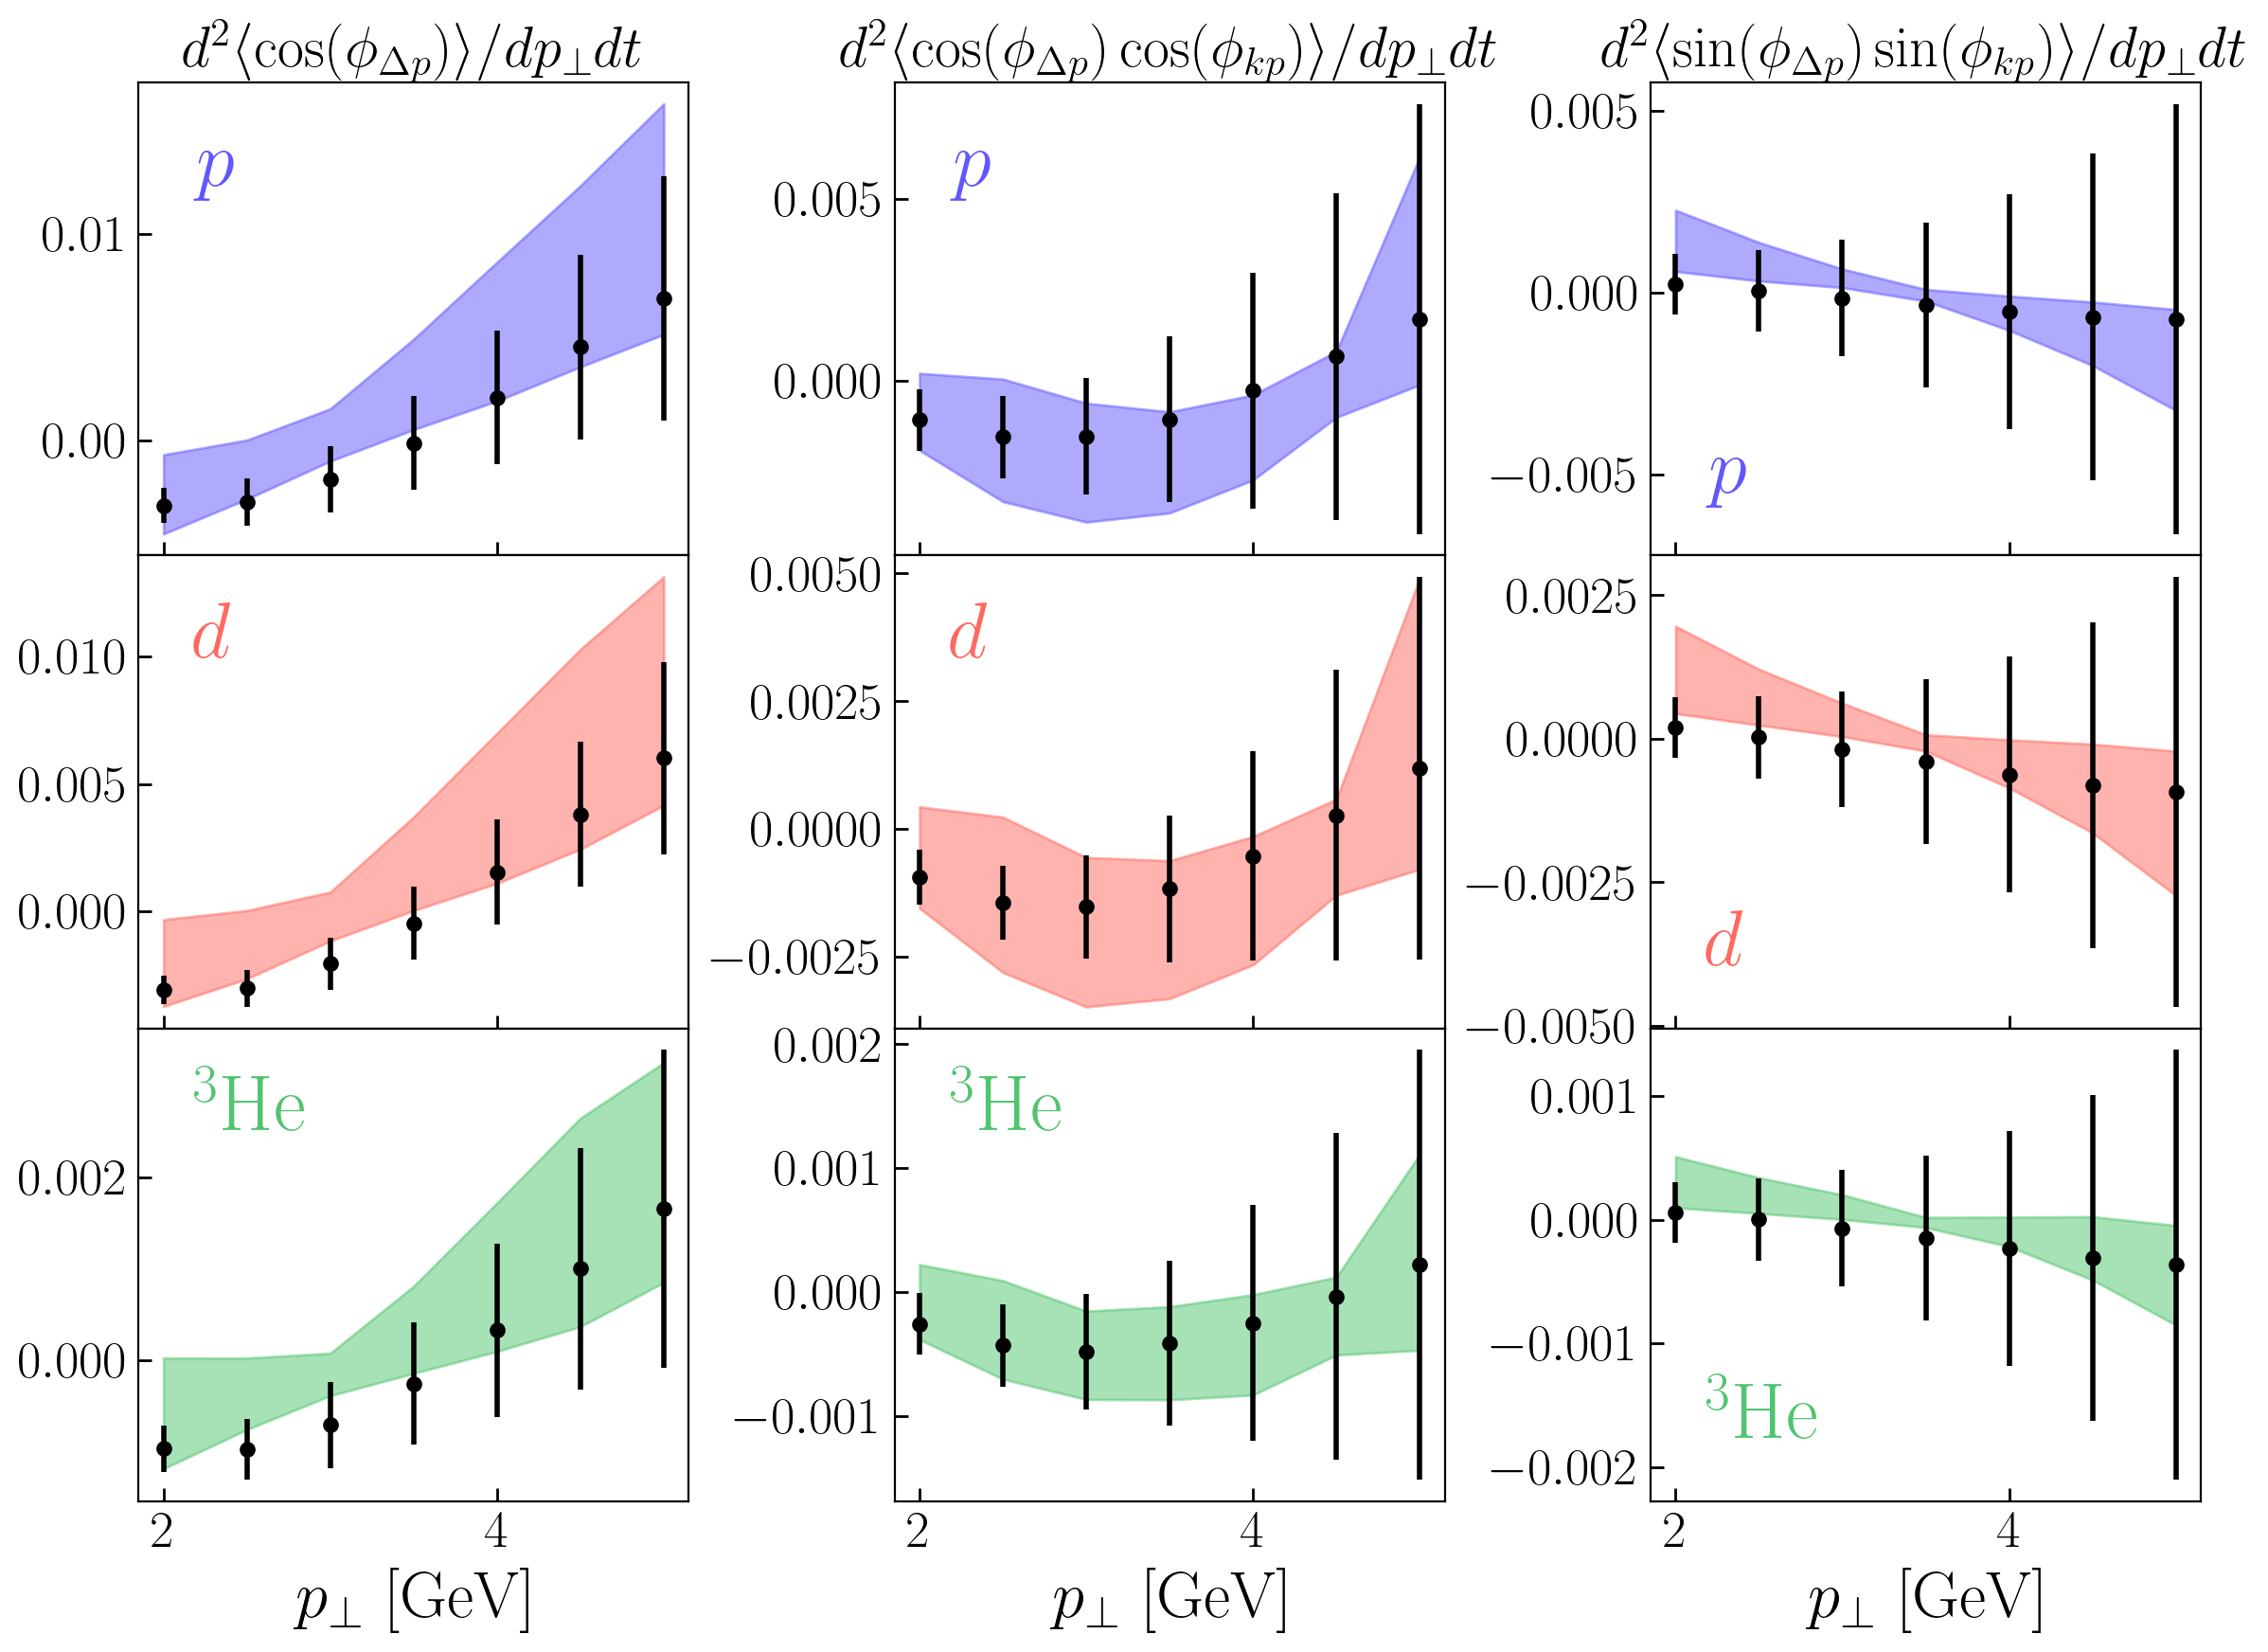

In [34]:
# dijet data v. theory plots
asp_ratio = 4/3
psize = 3
nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows), sharex='col')

save_plots = False
plot_bands = True

colors = ['#6257ff', '#FF6961', '#51c46f']
tar_to_idx = {2000: 'p', 2001:'d', 2002:'h'}
corrs = ['cos(phi_Dp)', 'cos(phi_Dp)cos(phi_kp)', 'sin(phi_Dp)sin(phi_kp)']

for irow, idx in enumerate(data['reactions']['pdijet']):
    # tar = data['reactions']['pdijet'][idx]['tar'][0]
    pT_values = np.unique(data['reactions']['pdijet'][idx]['PT'])
    obs_arr = np.array(data['reactions']['pdijet'][idx]['obs'])
    value_arr = np.array(data['reactions']['pdijet'][idx]['value'])
    stat_err_arr = np.array(data['reactions']['pdijet'][idx]['stat_u'])
    sys_err_arr = np.array(data['reactions']['pdijet'][idx]['sys_u'])
    pred_reps = data['reactions']['pdijet'][idx]['prediction-rep']
    
    for ic, corr in enumerate(np.unique(obs_arr)):

        value = value_arr[obs_arr==corr]
        stat_err = stat_err_arr[obs_arr==corr]
        sys_err = sys_err_arr[obs_arr==corr]
        
        ax[irow, ic].errorbar(
                pT_values, value, yerr=np.sqrt(stat_err**2 + sys_err**2), fmt='o',
                capsize=0, elinewidth=2, capthick=1, color='black', markersize=5
        )

        reps = [rep[obs_arr==corr] for rep in pred_reps]
        if plot_bands:
            confid = 68
            lower = np.percentile(reps, 0.5*(100-confid), axis=0, method='inverted_cdf')
            upper = np.percentile(reps, 100 - 0.5*(100-confid), axis=0, method='inverted_cdf')
            mean = np.mean(reps, axis=0)

            ax[irow, ic].fill_between(pT_values, lower, upper, color=colors[irow], alpha=0.5)

        else:
            for rep in reps:
                ax[irow, ic].plot(
                        pT_values, rep, color=colors[irow], linewidth=2, alpha=0.5
                )

tar_labels = [r'p', r'd', r'^3\mathrm{He}']
for irow in range(nrows):
    if irow == nrows-1:
        ax[irow, 0].set_xlabel(r'$p_{\perp}$ [GeV]')
        ax[irow, 1].set_xlabel(r'$p_{\perp}$ [GeV]')
        ax[irow, 2].set_xlabel(r'$p_{\perp}$ [GeV]')

    if irow == 0:
        ax[0,0].set_title(fr'$ d^2 \langle \cos(\phi_{{\Delta p}}) \rangle / dp_\perp dt$', size=22)
        ax[0,1].set_title(fr'$ d^2 \langle \cos(\phi_{{\Delta p}}) \cos(\phi_{{k p}}) \rangle / dp_\perp dt$', size=22)
        ax[0,2].set_title(fr'$ d^2 \langle \sin(\phi_{{\Delta p}}) \sin(\phi_{{k p}}) \rangle / dp_\perp dt$', size=22)

    for j in range(3): ax[irow, j].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=False, top=False)
    ax[irow, 0].text(
            0.1, 0.75, fr'${tar_labels[np.mod(int(irow), 3)]}$', 
            transform=ax[irow, 0].transAxes,
            ha='left', va='bottom', 
            fontsize=30, wrap=True, 
            color=colors[np.mod(int(irow), 3)],
            # bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
    )
    
    ax[irow, 1].text(
            0.1, 0.75, fr'${tar_labels[np.mod(int(irow), 3)]}$', 
            transform=ax[irow, 1].transAxes,
            ha='left', va='bottom', 
            fontsize=30, wrap=True, 
            color=colors[np.mod(int(irow), 3)],
            # bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
    )

    ax[irow, 2].text(
            0.1, 0.1, fr'${tar_labels[np.mod(int(irow), 3)]}$', 
            transform=ax[irow, 2].transAxes,
            ha='left', va='bottom', 
            fontsize=30, wrap=True, 
            color=colors[np.mod(int(irow), 3)],
            # bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
    )
    

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

if save_plots:
    if plot_bands: line = 'band'
    else: line = 'line'
    fig.savefig(f'{wdir}/gallery/datavtheory_dijet_{line}.pdf', dpi=400, bbox_inches="tight")


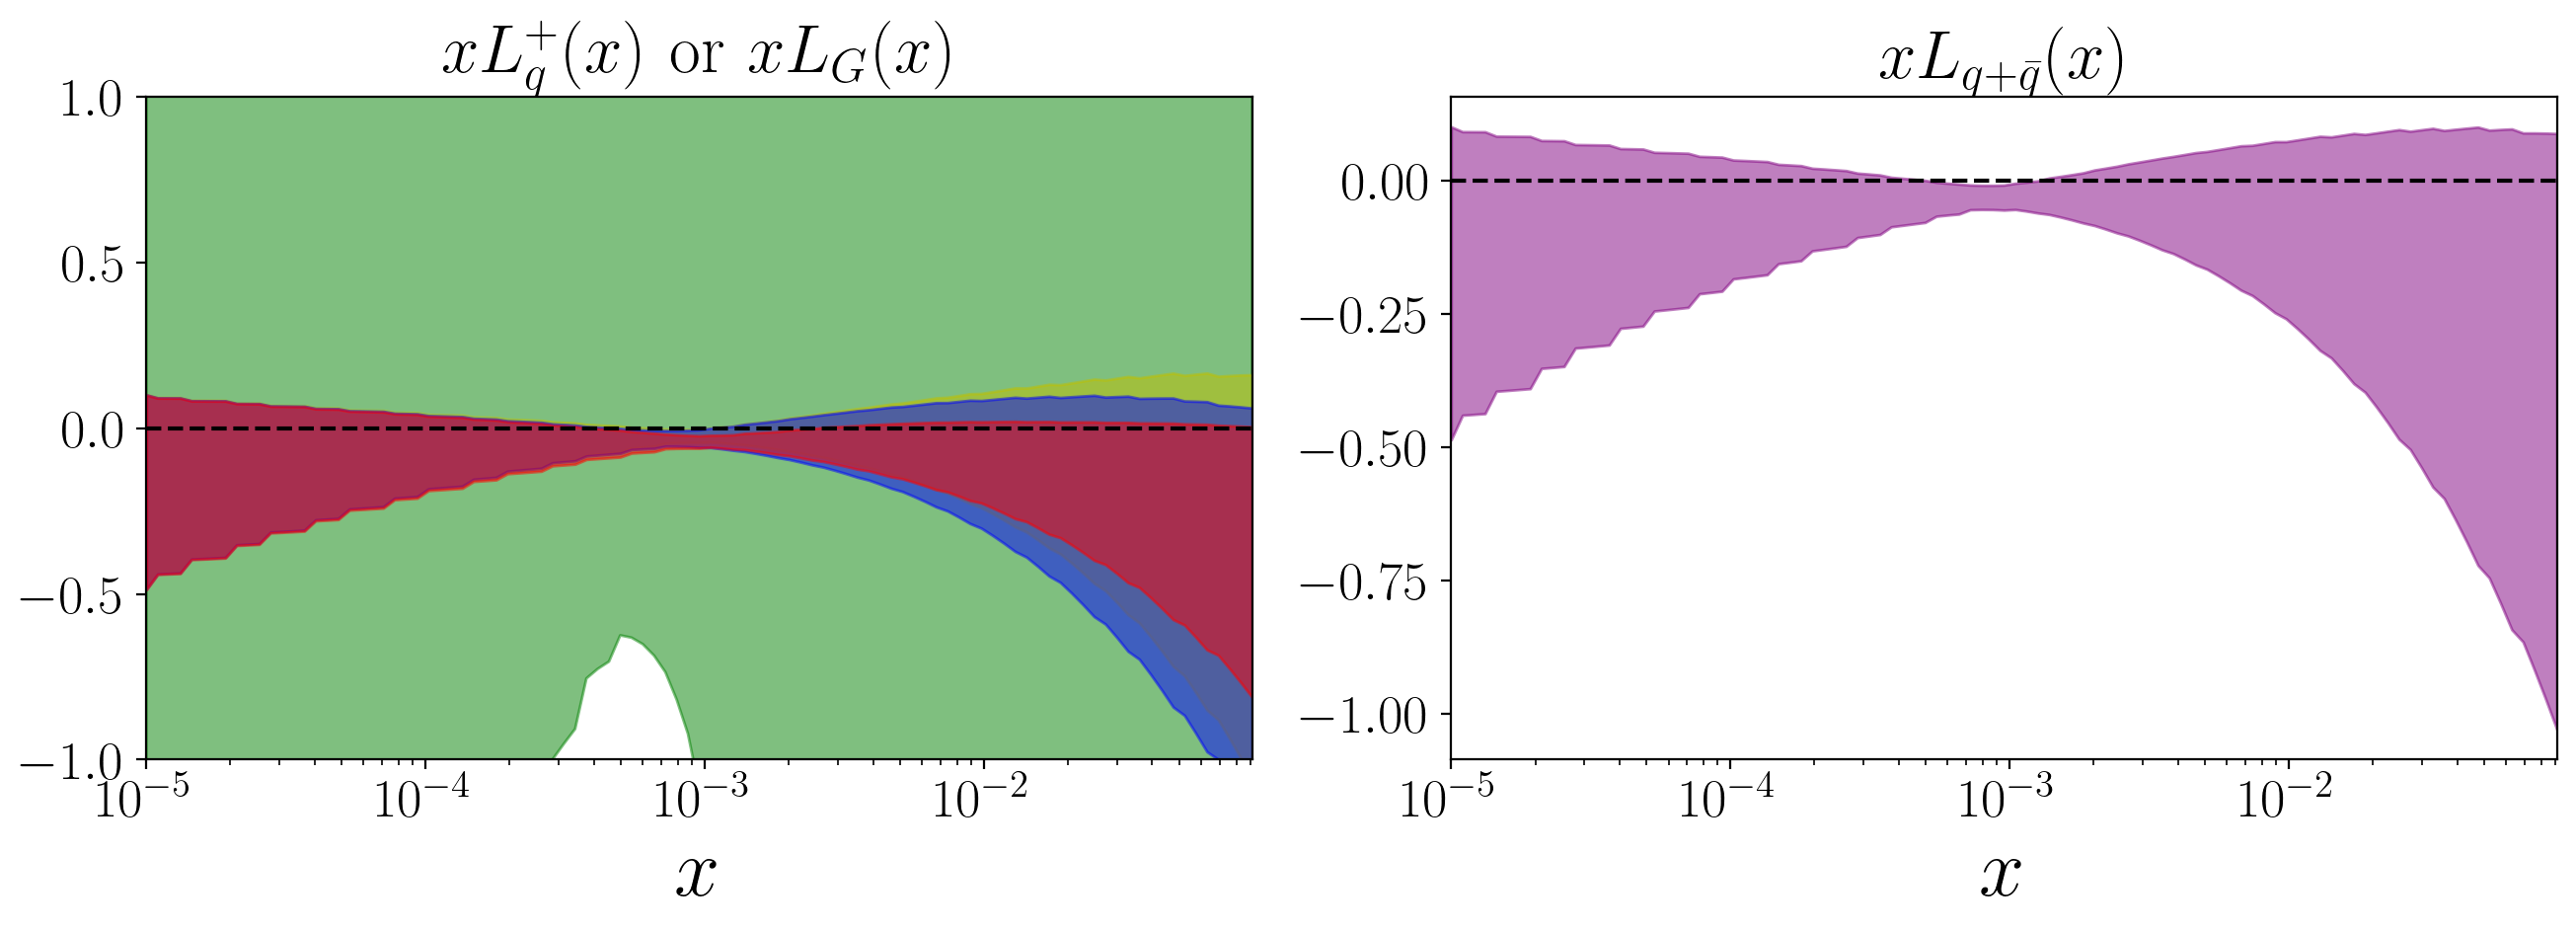

In [53]:
# oamd plots

def get_bands(reps): 
    # reps = pdf_data['XF'][flav]
    confid = 68
    # lower = np.percentile(reps, 0.5*(100-confid), axis=0, method='inverted_cdf')
    # upper = np.percentile(reps, 100 - 0.5*(100-confid), axis=0, method='inverted_cdf')
    lower = np.percentile(reps, 0.5*(100-confid), axis=0)
    upper = np.percentile(reps, 100 - 0.5*(100-confid), axis=0)
    std = np.std(reps,axis=0)
    mean = np.mean(reps, axis=0)
    lower = mean - std
    upper = mean + std

    return {'lower': lower, 'upper':upper, 'mean':mean}
    
asp_ratio = 4/3
psize = 5

separate_plots = False
save_plots = False
plot_bands = True
plot_bandwidths = False

if not separate_plots: nrows, ncols = 1, 2
else: nrows, ncols = 2,2
    
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows))
if not separate_plots: axs = ax
else: axs = [ax[irow, icol] for irow in range(nrows) for icol in range(ncols)]

# colors = ['#6257ff', '#FF6961', '#51c46f', 'green']
colors = ['g','y','b','r','purple']
flavors = ['Lg','Lsp','Ldp','Lup','Ls']
li = 1

for iflav, flav in enumerate(flavors):
    if not separate_plots: iax = 0
    else: iax = iflav

    if flav == 'Ls': 
        if separate_plots: continue
        reps = pdf_data['XF']['Lup'] + pdf_data['XF']['Ldp'] + pdf_data['XF']['Lsp']
        iax = 1
    else:
        reps = pdf_data['XF'][flav]
    bands = get_bands(reps)
    
    if plot_bandwidths: 
        axs[iax].plot(pdf_data['X'][:-li], np.abs(bands['upper'][:-li] - bands['lower'][:-li]), color=colors[iflav], alpha=1.0)
    elif plot_bands: 
        axs[iax].fill_between(pdf_data['X'][:-li], bands['lower'][:-li], bands['upper'][:-li], color=colors[iflav], alpha=0.5)
    else:
        for rep in reps:
            axs[iflav].plot(pdf_data['X'][:-li], rep[:-li], color=colors[0], alpha=0.2)

for ax in axs:
    ax.axhline(y=0, color='black', linestyle='--')
    # ax.axvline(x=0.01, color='gray', linestyle='-')
    ax.set_xlabel(r'$x$', size=30)
    ax.semilogx()
    ax.set_xmargin(0.0)
    # ax.text(
    #         0.3, 0.1, r'$Q^2 = 10\, \mathrm{GeV}^2$', 
    #         transform=axs[iflav].transAxes,
    #         ha='left', va='bottom', 
    #         fontsize=20, wrap=True, 
    #         color='black'
    # )

if not separate_plots:
    axs[0].set_title(r'$x L_q^+(x)\,\, \mathrm{or}\,\, xL_G(x)$', size=25)
    axs[1].set_title(r'$x L_{q+\bar{q}} (x)$', size=25)
    axs[0].set_ylim([-1 ,1])
else:
    axs[3].set_title(r'$x\Delta u^+(x)$', size=25)
    axs[2].set_title(r'$x\Delta {d}^+(x)$', size=25)
    axs[1].set_title(r'$x\Delta {s}^+(x)$', size=25)
    axs[0].set_title(r'$x\Delta {G}(x)$', size=25)
        
plt.tight_layout()
plt.show()

if save_plots:
    if plot_bands: line = 'band'
    else: line = 'line'
    fig.savefig(f'{wdir}/gallery/oamd_dijet_{line}.pdf', dpi=400, bbox_inches="tight")

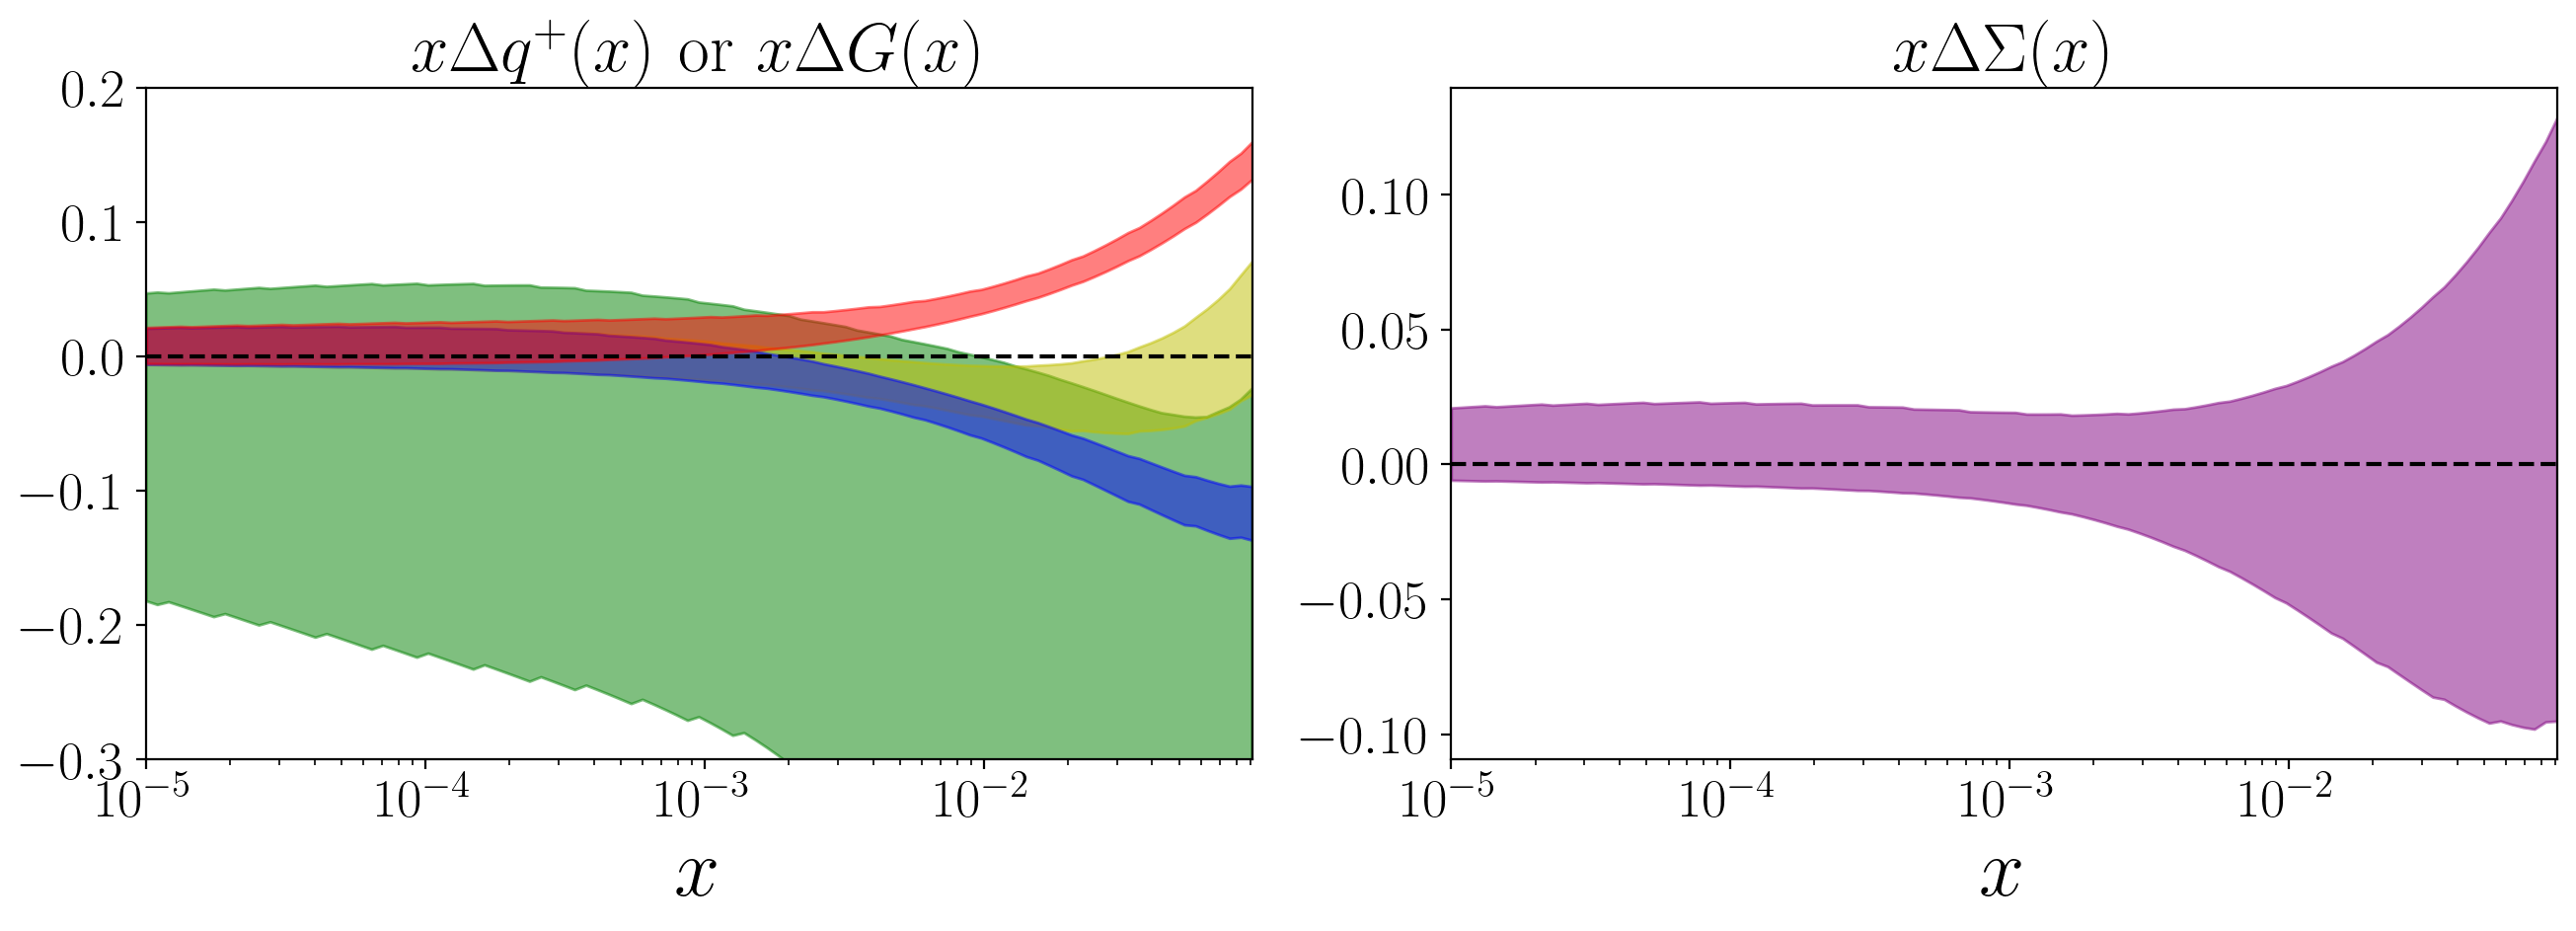

In [57]:
# hPDF plots

def get_bands(reps): 
    # reps = pdf_data['XF'][flav]
    confid = 68
    lower = np.percentile(reps, 0.5*(100-confid), axis=0, method='inverted_cdf')
    upper = np.percentile(reps, 100 - 0.5*(100-confid), axis=0, method='inverted_cdf')
    # lower = np.percentile(reps, 0.5*(100-confid), axis=0)
    # upper = np.percentile(reps, 100 - 0.5*(100-confid), axis=0)
    std = np.std(reps,axis=0)
    mean = np.mean(reps, axis=0)
    lower = mean - std
    upper = mean + std

    return {'lower': lower, 'upper':upper, 'mean':mean}
    
asp_ratio = 4/3
psize = 5

separate_plots = False
save_plots = False
plot_bands = True
plot_bandwidths = False

if not separate_plots: nrows, ncols = 1, 2
else: nrows, ncols = 2,2
    
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows))
if not separate_plots: axs = ax
else: axs = [ax[irow, icol] for irow in range(nrows) for icol in range(ncols)]

# colors = ['#6257ff', '#FF6961', '#51c46f', 'green']
colors = ['g','y','b','r','purple']
flavors = ['g','sp','dp','up','ds']
li = 1

for iflav, flav in enumerate(flavors):
    if not separate_plots: iax = 0
    else: iax = iflav

    if flav == 'ds': 
        if separate_plots: continue
        reps = pdf_data['XF']['up'] + pdf_data['XF']['dp'] + pdf_data['XF']['sp']
        iax = 1
    else:
        reps = pdf_data['XF'][flav]
    bands = get_bands(reps)
    
    if plot_bandwidths: 
        axs[iax].plot(pdf_data['X'][:-li], np.abs(bands['upper'][:-li] - bands['lower'][:-li]), color=colors[iflav], alpha=1.0)
    elif plot_bands: 
        axs[iax].fill_between(pdf_data['X'][:-li], bands['lower'][:-li], bands['upper'][:-li], color=colors[iflav], alpha=0.5)
    else:
        for rep in reps:
            axs[iflav].plot(pdf_data['X'][:-li], rep[:-li], color=colors[0], alpha=0.2)



for ax in axs:
    ax.axhline(y=0, color='black', linestyle='--')
    # ax.axvline(x=0.01, color='gray', linestyle='-')
    ax.set_xlabel(r'$x$', size=30)
    ax.semilogx()
    ax.set_xmargin(0.0)
    # ax.text(
    #         0.3, 0.1, r'$Q^2 = 10\, \mathrm{GeV}^2$', 
    #         transform=axs[iflav].transAxes,
    #         ha='left', va='bottom', 
    #         fontsize=20, wrap=True, 
    #         color='black'
    # )

if not separate_plots:
    axs[0].set_title(r'$x\Delta q^+(x)\,\, \mathrm{or}\,\, x\Delta G(x)$', size=25)
    axs[1].set_title(r'$x\Delta \Sigma (x)$', size=25)
    axs[0].set_ylim([-0.3, 0.2])
else:
    axs[3].set_title(r'$x\Delta u^+(x)$', size=25)
    axs[2].set_title(r'$x\Delta {d}^+(x)$', size=25)
    axs[1].set_title(r'$x\Delta {s}^+(x)$', size=25)
    axs[0].set_title(r'$x\Delta {G}(x)$', size=25)
        
plt.tight_layout()
plt.show()

if save_plots:
    if plot_bands: line = 'band'
    else: line = 'line'
    fig.savefig(f'{wdir}/gallery/hpdf_dijet_{line}.pdf', dpi=400, bbox_inches="tight")